# Final Tests of New Coordinates Approach

In [1]:
import subprocess
import os

import numpy as np
import dask
import dask.distributed
from scipy.interpolate import splev,splprep
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import sunpy.map
import sunpy
from sunpy.util.metadata import MetaDict
import sunpy.sun.constants
import sunpy.coordinates
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord

import synthesizAR
import synthesizAR.extrapolate
import synthesizAR.util
import synthesizAR.maps
from synthesizAR.interfaces import UniformHeating,EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:64593 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Magnetic Skeleton

First, get the magnetogram and crop and resample it appropriately.

In [ ]:
hmi = sunpy.map.Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2010_09_29_23_52_30_tai_magnetogram.fits').rotate()
width = 300*u.arcsec
height = 300*u.arcsec
lc = SkyCoord(361.5*u.arcsec-width/2, 261.5*u.arcsec-height/2,frame=hmi.coordinate_frame)
rc = SkyCoord(361.5*u.arcsec+width/2, 261.5*u.arcsec+height/2,frame=hmi.coordinate_frame)
hmi = hmi.submap(lc,rc).resample([100,100]*u.pixel)

In [ ]:
hmi.peek(cmap='hmimag',vmin=-1.5e3,vmax=1.5e3)

Next, extrapolate the 3D magnetic field from the magnetogram using a potential field extrapolation.

In [ ]:
extrapolator = synthesizAR.extrapolate.ObliqueSchmidt(hmi, width_z=0.5*sunpy.sun.constants.radius,
                                                      shape_z=100*u.pixel)

In [ ]:
B_field = extrapolator.extrapolate()

In [ ]:
fieldlines = extrapolator.trace_fieldlines(B_field, 500, 
                                           #loop_length_range=[1e9,2e10]*u.cm, 
                                           mask_threshold=0.15
                                          )

In [ ]:
active_region = synthesizAR.Field(hmi, fieldlines)

In [ ]:
active_region.peek(line_frequency=2,alpha=0.75)

In [ ]:
plt.hist([loop.full_length.to(u.Mm).value for loop in active_region.loops],histtype='step',lw=2);
plt.ylabel('Number of loops')
plt.xlabel('Loop length [Mm]')

In [ ]:
for loop in active_region.loops:
    plt.plot(loop.field_aligned_coordinate/loop.full_length, loop.field_strength, 'C0', alpha=0.05)

Next, do an EBTEL simulation for each of the loops.

In [ ]:
heating_options = {
    'duration':200,
    'average_waiting_time':4800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.1
}
heating_model = UniformHeating(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [ ]:
ebtel_interface = EbtelInterface(base_config, heating_model, 
                                 '/Users/willbarnes/Desktop/test/hydro_config/',
                                 '/Users/willbarnes/Desktop/test/hydro_results/')

In [ ]:
active_region.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [ ]:
active_region.load_loop_simulations(ebtel_interface, '/Users/willbarnes/Desktop/test/loop_parameters.h5')

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(15,8),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in active_region.loops[::2]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.1)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim([0,5000])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Save and reload the field as needed.

In [ ]:
active_region.save('/Users/willbarnes/Desktop/test/field_checkpoint')

In [3]:
active_region = synthesizAR.Field.restore('/Users/willbarnes/Desktop/test/field_checkpoint/')

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/synthesizAR-0.1.dev568-py3.6.egg/synthesizAR/field.py:41: UserWarning: Fieldlines not found. No loops will be created.
  warnings.warn('Fieldlines not found. No loops will be created.')


## Synthesize Emission
Now compute SDO data products for the active region

In [5]:
hgs_center = active_region.magnetogram.center.transform_to('heliographic_stonyhurst')
aia_obs_coord = SkyCoord(lon=-75*u.deg,#active_region.magnetogram.observer_coordinate.lon,
                         lat=active_region.magnetogram.observer_coordinate.lat,
                         radius=active_region.magnetogram.observer_coordinate.radius,
                         frame='heliographic_stonyhurst')
aia = InstrumentSDOAIA([500,600]*u.s,observer_coordinate=aia_obs_coord)

In [6]:
observer = synthesizAR.Observer(active_region,[aia],parallel=True)

In [7]:
observer.build_detector_files('/Users/willbarnes/Desktop/test/',ds=0.3*u.arcsec)

/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar_coords/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [8]:
tasks = observer.flatten_detector_counts()

In [9]:
tasks['SDO_AIA_counts'].compute()

In [10]:
tasks['SDO_AIA_parameters'].compute()

In [11]:
vlos_map = synthesizAR.maps.make_los_velocity_map(500*u.s, active_region, aia)
tmp = gaussian_filter(vlos_map.data, (aia.channels[0]['gaussian_width']['y'].value,
                                      aia.channels[0]['gaussian_width']['x'].value
                                     ))
vlos_map = sunpy.map.GenericMap(tmp, vlos_map.meta, plot_settings=vlos_map.plot_settings)

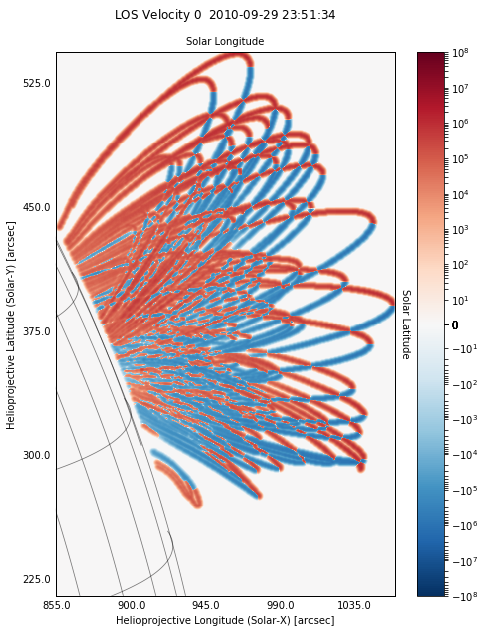

In [12]:
fig = plt.figure(figsize=(8,10))
ax = fig.gca(projection=vlos_map)
im = vlos_map.plot(axes=ax,cmap='RdBu_r')
ax.grid(alpha=0)
vlos_map.draw_grid(color='k',grid_spacing=5*u.deg,axes=ax)
fig.colorbar(im)

In [13]:
temp_map = synthesizAR.maps.make_temperature_map(500*u.s, active_region, aia)
tmp = gaussian_filter(temp_map.data, (aia.channels[0]['gaussian_width']['y'].value,
                                      aia.channels[0]['gaussian_width']['x'].value
                                     ))
temp_map = sunpy.map.GenericMap(tmp, temp_map.meta, plot_settings=temp_map.plot_settings)

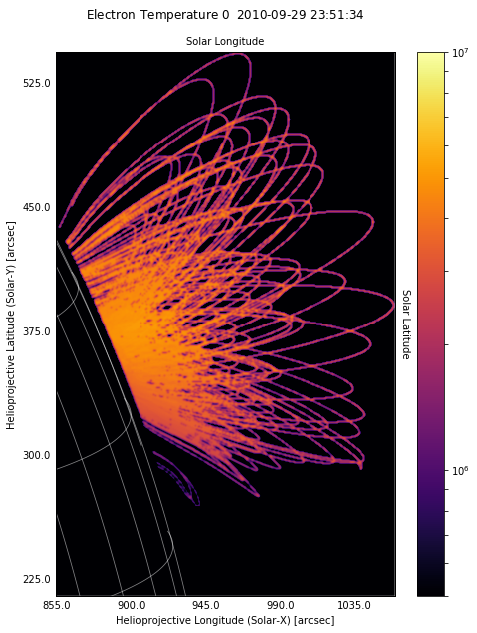

In [14]:
fig = plt.figure(figsize=(8,10))
ax = fig.gca(projection=temp_map)
im = temp_map.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=5e5,vmax=1e7))
ax.grid(alpha=0)
temp_map.draw_grid(color='w',grid_spacing=5*u.deg,axes=ax)
fig.colorbar(im)

In [15]:
em_cube = synthesizAR.maps.make_emission_measure_map(500 * u.s, active_region,
                                                     aia,
                                                     temperature_bin_edges=np.logspace(5.5,7.5,10)*u.K,)

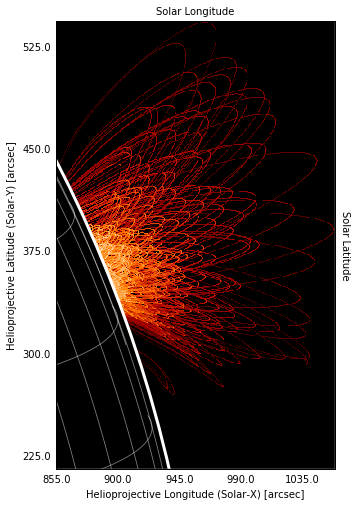

In [35]:
em_slice = em_cube.total_emission
#tmp = gaussian_filter(em_slice.data, (5,#aia.channels[0]['gaussian_width']['y'].value,
#                                      5#aia.channels[0]['gaussian_width']['x'].value
#                                     ))
tmp = em_slice.data
em_slice = sunpy.map.GenericMap(tmp, em_slice.meta, plot_settings=em_slice.plot_settings)
fig = plt.figure(figsize=(5,10))
ax = fig.gca(projection=em_slice,)
em_slice.plot(axes=ax, title=False, cmap='hinodexrt',
              norm=matplotlib.colors.SymLogNorm(1,vmin=1e24,vmax=1e29))
#ax.set_title(f'{np.log10(em_slice.meta["temp_a"]):.3f} - {np.log10(em_slice.meta["temp_b"]):.3f}')
ax.grid(alpha=0)
em_slice.draw_grid(color='w',grid_spacing=5*u.deg,axes=ax)
limb = em_slice.draw_limb(axes=ax,color='w',lw=3,alpha=1)

Finally, make detector count maps

In [17]:
tasks = observer.bin_detector_counts('/Users/willbarnes/Desktop/test/')

In [18]:
jobs = client.compute(tasks['SDO_AIA'])

In [19]:
jobs = None

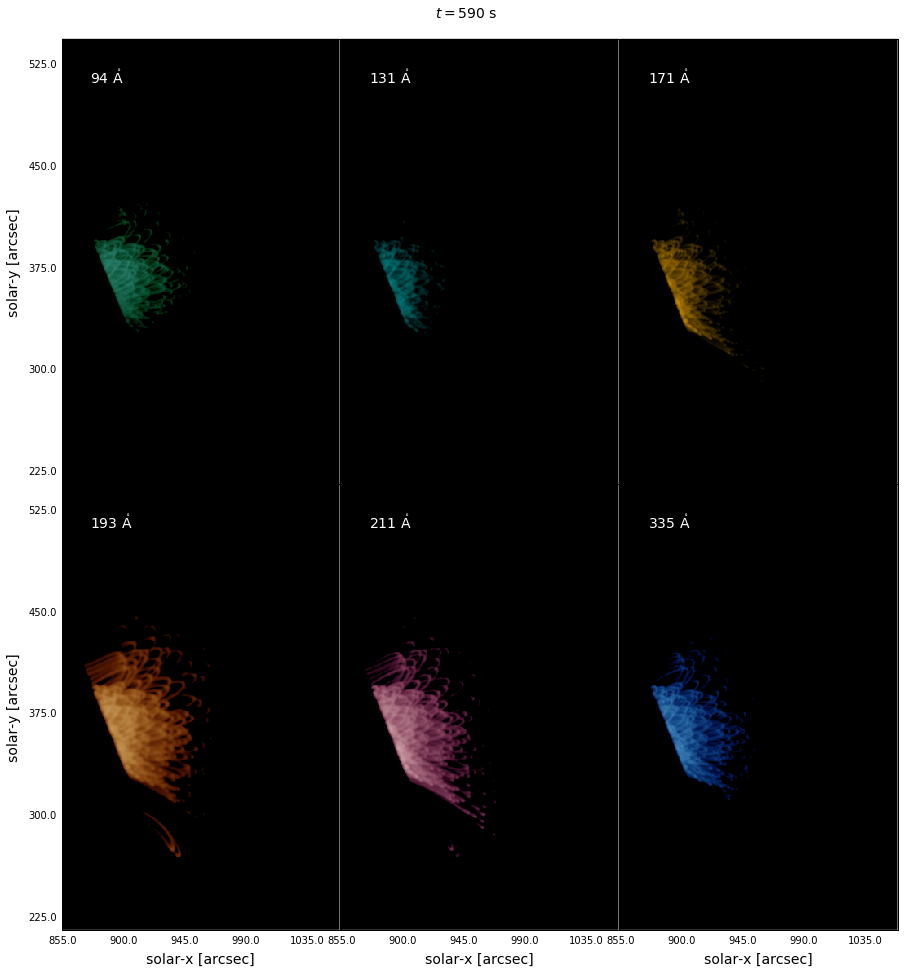

In [31]:
plot_aia_channels(aia, 590*u.s, '/Users/willbarnes/Desktop/test/',figsize=(15,15),)

## Sandbox Masking Intensity from Behind the limb

In [ ]:
test_obs = SkyCoord(lon=0*u.deg,#active_region.magnetogram.observer_coordinate.lon,
                    lat=0*u.deg,#active_region.magnetogram.observer_coordinate.lat,
                    radius=active_region.magnetogram.observer_coordinate.radius,
                    frame='heliographic_stonyhurst')
aia_test = InstrumentSDOAIA([1000,1110]*u.s,observer_coordinate=test_obs)

In [ ]:
observer_test = synthesizAR.Observer(active_region,[aia_test],parallel=False)

In [ ]:
observer_test.build_detector_files('/Users/willbarnes/Desktop/test/sand/',ds=0.3*u.arcsec)

In [ ]:
observer_test.flatten_detector_counts()

In [ ]:
temp_map = synthesizAR.maps.make_temperature_map(1000*u.s, active_region, aia_test)
fig = plt.figure(figsize=(8,10))
ax = fig.gca(projection=temp_map)
ax.set_facecolor('k')
im = temp_map.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=5e5,vmax=1e7))
ax.grid(alpha=0)
temp_map.draw_grid(color='w',grid_spacing=5*u.deg,axes=ax)
temp_map.draw_limb(axes=ax,color='w',lw=3,alpha=1)
fig.colorbar(im)
#ax.plot_coord(SkyCoord(-1000*u.arcsec,-1000*u.arcsec,frame=temp_map.coordinate_frame),'ok')
#ax.plot_coord(SkyCoord(1000*u.arcsec,1000*u.arcsec,frame=temp_map.coordinate_frame),'ok')

In [ ]:
theta_x = aia_test.total_coordinates.Tx
theta_y = aia_test.total_coordinates.Ty
distance = aia_test.total_coordinates.distance
rsun_obs = ((sunpy.sun.constants.radius / (aia_test.observer_coordinate.radius - sunpy.sun.constants.radius))
            .decompose() * u.radian).to(u.arcsec)

In [ ]:
off_disk = np.sqrt(theta_x**2 + theta_y**2) > rsun_obs

In [ ]:
in_front_of_disk = distance - aia_test.observer_coordinate.radius < 0.

In [ ]:
visible = np.any(np.stack([off_disk,in_front_of_disk],axis=1),axis=1)

In [ ]:
header = aia_test.make_fits_header(active_region, aia_test.channels[0])
weights = np.ones(aia_test.total_coordinates.Tx.shape)
dz = np.diff(aia_test.bin_range.z).to('cm')[0] / aia_test.bins.z * (1. * u.pixel)
#visible = is_visible(aia_test.total_coordinates, aia_test.observer_coordinate)
hist, _, _ = np.histogram2d(aia_test.total_coordinates.Tx.value, 
                            aia_test.total_coordinates.Ty.value,
                            bins=(aia_test.bins.x.value, 
                                  aia_test.bins.y.value),
                            range=(aia_test.bin_range.x.value, 
                                   aia_test.bin_range.y.value),
                            weights=visible)
#counts = gaussian_filter(hist.T, (aia_test.channels[0]['gaussian_width']['y'].value,
#                                  aia_test.channels[0]['gaussian_width']['x'].value))
counts = hist.T
test_map = sunpy.map.Map(counts, header)

In [ ]:
fig = plt.figure(figsize=(8,10))
ax = fig.gca(projection=test_map)
ax.set_facecolor('k')
im = test_map.plot(axes=ax,vmin=0,vmax=1)
ax.grid(alpha=0)
test_map.draw_grid(color='w',grid_spacing=5*u.deg,axes=ax)
test_map.draw_limb(axes=ax,color='r',lw=3,alpha=1)
fig.colorbar(im)
#ax.plot_coord(SkyCoord(-1000*u.arcsec,-1000*u.arcsec,frame=test_map.coordinate_frame),'ok')
#ax.plot_coord(SkyCoord(1000*u.arcsec,1000*u.arcsec,frame=test_map.coordinate_frame),'ok')

## Interpolation and Binning Sandbox

In [ ]:
np.stack([aia.total_coordinates.Tx,aia.total_coordinates.Ty],axis=1).shape

In [ ]:
np.diff(aia.bin_range.x)/aia.bins.x.value*np.arange(aia.bins.x.value+1) + aia.bin_range.x[0]

In [ ]:
np.arange(aia.bins.x + 1 * u.pixel)

In [ ]:
sdo_observer = SkyCoord(lon=-45*u.deg,#active_region.magnetogram.observer_coordinate.lon,
                        lat=active_region.magnetogram.observer_coordinate.lat,
                        radius=1*active_region.magnetogram.observer_coordinate.radius,
                        frame='heliographic_stonyhurst')

In [ ]:
ds = ((0.3*u.arcsec).to(u.radian).value * (sdo_observer.radius - sunpy.sun.constants.radius)).to(u.cm)
all_heeq_coords = []
interp_s = []
for loop in active_region.loops:
    n_interp = int(np.ceil(loop.full_length/ds))
    interpolated_s = np.linspace(loop.field_aligned_coordinate.value[0],
                                 loop.field_aligned_coordinate.value[-1], n_interp)
    interp_s.append(interpolated_s)
    nots, _ = splprep(loop.coordinates.value.T)
    all_heeq_coords.append(np.array(splev(np.linspace(0, 1, n_interp), nots)).T)
all_heeq_coords = np.vstack(all_heeq_coords) * loop.coordinates.unit

In [ ]:
all_hcc_coords = u.Quantity(synthesizAR.util.heeq_to_hcc(all_heeq_coords[:,0],
                                                         all_heeq_coords[:,1],
                                                         all_heeq_coords[:,2],
                                                         sdo_observer)).T
all_hcc_coords = SkyCoord(x=all_hcc_coords[:,0],
                          y=all_hcc_coords[:,1],
                          z=all_hcc_coords[:,2],
                          frame=sunpy.coordinates.frames.Heliocentric(observer=sdo_observer))

In [ ]:
all_hpc_coords = all_hcc_coords.transform_to(sunpy.coordinates.frames.Helioprojective(observer=sdo_observer))

In [ ]:
# Bottom left corner of magnetogram
fov_left_corner = (active_region.magnetogram.bottom_left_coord
                   .transform_to('heliographic_stonyhurst')
                   .transform_to(sunpy.coordinates.frames.Helioprojective(observer=sdo_observer)))
fov_right_corner = (active_region.magnetogram.top_right_coord
                    .transform_to('heliographic_stonyhurst')
                    .transform_to(sunpy.coordinates.frames.Helioprojective(observer=sdo_observer)))
min_x = min(all_hpc_coords.Tx.min(),fov_left_corner.Tx) - 5.*u.arcsec
max_x = max(all_hpc_coords.Tx.max(),fov_right_corner.Tx) + 5.*u.arcsec
min_y = min(all_hpc_coords.Ty.min(),fov_left_corner.Ty) - 5.*u.arcsec
max_y = max(all_hpc_coords.Ty.max(),fov_right_corner.Ty) + 5.*u.arcsec
delta_x = max_x - min_x
delta_y = max_y - min_y
res_x,res_y = 0.6*u.arcsec/u.pixel, 0.6*u.arcsec/u.pixel
bins = synthesizAR.util.SpatialPair(x=int(np.ceil(delta_x/res_x).value), 
                                    y=int(np.ceil(delta_y/res_y).value),
                                    z=None)
bin_range = synthesizAR.util.SpatialPair(x=u.Quantity([min_x,max_x]).value, 
                                         y=u.Quantity([min_y,max_y]).value,
                                         z=u.Quantity([all_hpc_coords.distance.to(u.cm).min(),
                                                       all_hpc_coords.distance.to(u.cm).max()]))

In [ ]:
np.ceil(delta_x/aia.resolution.x)

In [ ]:
aia = InstrumentSDOAIA([0,5000]*u.s)

In [ ]:
selected_channel = aia.channels[3]

In [ ]:
weights = []
for i,loop in enumerate(active_region.loops):
    # Calculate counts
    c = aia.calculate_counts_simple(selected_channel,loop)
    # Interpolate to get weights
    c_interp = aia.interpolate_and_store(c,loop,aia.observing_time,interp_s[i])
    # Save a single slice in time
    weights += c_interp[300,:].value.tolist()
weights = np.array(weights)

In [ ]:
dz = (all_hpc_coords.distance.to(u.cm).max() - all_hpc_coords.distance.to(u.cm).min())/max(bins.x,bins.y) 

In [ ]:
hist,_,_ = np.histogram2d(all_hpc_coords.Tx.value,all_hpc_coords.Ty.value,
                        bins=(bins.x, bins.y), range=(bin_range.x, bin_range.y),
                        weights=weights * dz)

In [ ]:
active_region.magnetogram.meta['dsun_obs']*u.m

In [ ]:
sunpy.sun.constants.au

In [ ]:
sdo_meta = MetaDict()
sdo_meta['telescop'] = 'SDO/AIA'
sdo_meta['detector'] = 'AIA'
sdo_meta['waveunit'] = 'angstrom'
sdo_meta['crval1'] = (min_x + delta_x/2).value
sdo_meta['crval2'] = (min_y + delta_y/2).value
sdo_meta['cunit1'] = all_hpc_coords.Tx.unit.to_string()
sdo_meta['cunit2'] = all_hpc_coords.Ty.unit.to_string()
sdo_meta['hglt_obs'] = sdo_observer.lat.value
sdo_meta['hgln_obs'] = sdo_observer.lon.value
sdo_meta['ctype1'] = 'HPLN-TAN'
sdo_meta['ctype2'] = 'HPLT-TAN'
sdo_meta['date-obs'] = active_region.magnetogram.meta['date-obs']
sdo_meta['dsun_obs'] = sdo_observer.radius.value
sdo_meta['rsun_obs'] = ((sunpy.sun.constants.radius.to(u.m) 
                        / (sdo_observer.radius - sunpy.sun.constants.radius).to(u.m)) * u.radian).to(u.arcsec).value
sdo_meta['cdelt1'] = res_x.value
sdo_meta['cdelt2'] = res_y.value
sdo_meta['crpix1'] = (bins.x + 1.)/2.
sdo_meta['crpix2'] = (bins.y + 1.)/2.
sdo_meta['instrume'] = selected_channel['instrument_label']
sdo_meta['wavelnth'] = selected_channel['wavelength'].value
sdo_meta['bunit'] = (c.unit * all_hcc_coords.z.unit).to_string()

In [ ]:
counts = gaussian_filter(hist.T, (selected_channel['gaussian_width']['y'].value,
                                  selected_channel['gaussian_width']['x'].value,))
#counts = np.where(counts==0,np.nan,counts)
sdo_map = sunpy.map.Map(counts,sdo_meta)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=sdo_map)
ax.set_facecolor('k')
cmap = sunpy.cm.get_cmap('hinodexrt')
cmap.set_bad(color='w')
im = sdo_map.plot(norm = matplotlib.colors.SymLogNorm(1e-10,vmin=1e-1,vmax=5e2))
ax.grid(alpha=0)
sdo_map.draw_grid(color='w',axes=ax,grid_spacing=10*u.deg,alpha=0.3)
#fig.colorbar(im)
#ax.plot_coord(SkyCoord(100*u.arcsec,0*u.arcsec,frame=sdo_map.coordinate_frame),'ok')
#ax.plot_coord(SkyCoord(750*u.arcsec,800*u.arcsec,frame=sdo_map.coordinate_frame),'ok')

### Sandbox

In [ ]:
hcc_frame = SkyCoord(x=xhcc,y=yhcc,z=zhcc,
                     frame=sunpy.coordinates.frames.Heliocentric(observer=active_region.magnetogram.observer_coordinate),)

In [ ]:
hpc_frame = hcc_frame.transform_to(sunpy.coordinates.frames.Helioprojective(observer=active_region.magnetogram.observer_coordinate))

In [ ]:
hpc_frame

In [ ]:
active_region.magnetogram.meta['crln_obs']

In [ ]:
active_region.magnetogram.center

In [ ]:
active_region.magnetogram.reference_coordinate

In [ ]:
class Parent(object):
    fits_template = sunpy.util.MetaDict()

In [ ]:
class Child(Parent):
    def __init__(self):
        self.fits_template['hello'] = 'world'

In [ ]:
c = Child()

In [ ]:
c.fits_template